In [1]:
%config Completer.use_jedi = False

In [82]:
from utils import *
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from numpy import nan
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import pingouin as pg

In [136]:
def read_parameter_data(path,names):
    
    data = []
    for name in names:
        inputData = pd.read_csv("{}{}.csv".format(path,name),dtype=object)
        inputData.infer_objects()#convert_dtypes(convert_string=False)
   
        data.append(pd.DataFrame(inputData))
    return data    
def parse_parameter_data(names,data):
    returnData = []
    for name, algoData in zip(names,data):
        results_dict = algoData['results']
        params_dict = algoData['parameters']
        result_values = {}
        result_values["paramGroup"] = []
        
        for key in eval(params_dict.iloc[0]).keys():
            result_values[key]=[]
        
        
        for key in eval(results_dict.iloc[0]).keys():
            result_values[key] = []
        
        
        #generate_param_groups(params_dict)
        
        for resultRow in algoData.iterrows():
            
            
            
            rowParameters = eval(resultRow[1]['parameters'])
            
            rowResults = eval(resultRow[1]['results'])
            
            for listIndex in range(len(rowResults["fitness"])):
                for paramKey in rowParameters.keys():
                    result_values[paramKey].append(rowParameters[paramKey])
                    

                for resultKey in rowResults.keys():
                    
                    
                    result_values[resultKey].append(rowResults[resultKey][listIndex])
                    if type(rowResults[resultKey][listIndex]) == list:
                        finalKey = "{}_final".format(resultKey)

                        if not finalKey in result_values.keys():
                            result_values[finalKey] = []
                        if len(rowResults[resultKey][listIndex]) > 50:
                            
                            result_values[finalKey].append(rowResults[resultKey][listIndex][50])
                        else:
                            result_values[finalKey].append(rowResults[resultKey][listIndex])
                            
                
        #print(result_values)
        returnData.append(pd.DataFrame(result_values))
        
        
        
    return returnData

def anova_plot(data,variable_field,between_fields):
    plt.figure(figsize=(10,10))
    tukey = pairwise_tukeyhsd(endog=data[variable_field],groups=data[between_fields],alpha=0.05)
    tukey.plot_simultaneous()
    plt.show()
    summary = tukey.summary()
    summary_as_html = summary.as_html()
    summary_df = pd.read_html(summary_as_html, header=0, index_col=0)[0]
    summary_df.where(summary_df.reject == True,inplace=True)
    summary_df.dropna(inplace=True)
    display(summary_df)
    
def anova_test(data,variable_field,between_fields):
    aov = pg.anova(dv=variable_field,between = between_fields,data=data,detailed=True)
    return aov

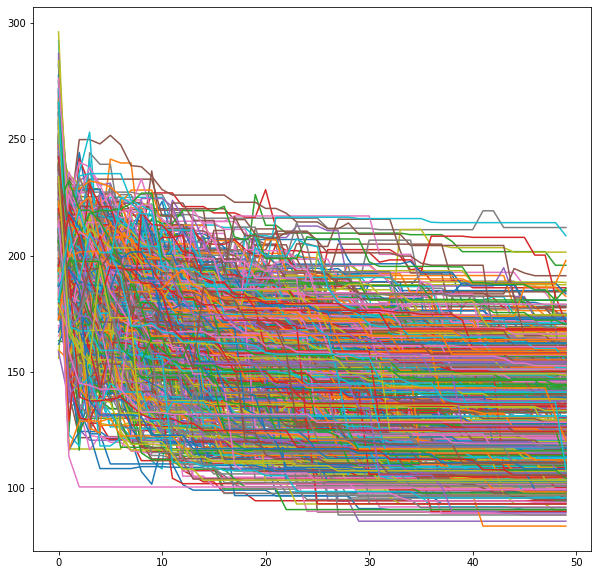

In [137]:
plt.figure(figsize=(10,10))
for x in nsga2_data.fitness:
    plt.plot(x[:50])

In [138]:
names = ["SA_20","LS_20","GA_20","HYPE_20","NSGAII_20","NSGAIII_20"]
dataPath = "../logs/2021-2-17-15-37/"
sa_data,ls_data,ga_data,hype_data,nsga2_data,nsga3_data = parse_parameter_data(names,read_parameter_data(dataPath,names))
#nsgaiii_data = algorithm_data[0]

In [139]:
ga_data.where(ga_data.violation_final == 0,inplace=True)
ga_data.dropna(inplace=True)
sa_data.where(sa_data.violation_final == 0,inplace=True)
sa_data.dropna(inplace=True)

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,13772.191886,4,3443.047972,6.809706,0.000049,0.163854
1,Within,70279.632244,139,505.608865,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,paramGroup,13772.191886,4,3443.047972,6.809706,0.000049,0.163854
1,Within,70279.632244,139,505.608865,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

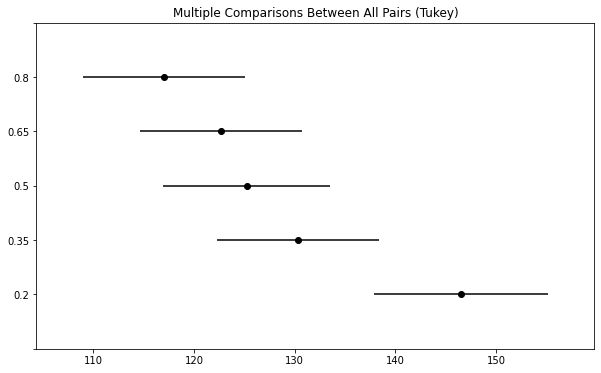

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0.2,0.50,-21.2986,0.0060,-38.2254,-4.3718,1.0
0.2,0.65,-23.8559,0.0011,-40.5088,-7.2030,1.0
0.2,0.80,-29.5153,0.0010,-46.1682,-12.8623,1.0


In [142]:
display(anova_test(sa_data,'fuel_consumption_final','mutation'))
display(anova_test(sa_data,'fuel_consumption_final','paramGroup'))
anova_plot(sa_data,'fuel_consumption_final','mutation')

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,21912.024214,4,5478.006054,11.424082,4.350543e-08,0.239629
1,Within,69529.515851,145,479.513902,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,paramGroup,21912.024214,4,5478.006054,11.424082,4.350543e-08,0.239629
1,Within,69529.515851,145,479.513902,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

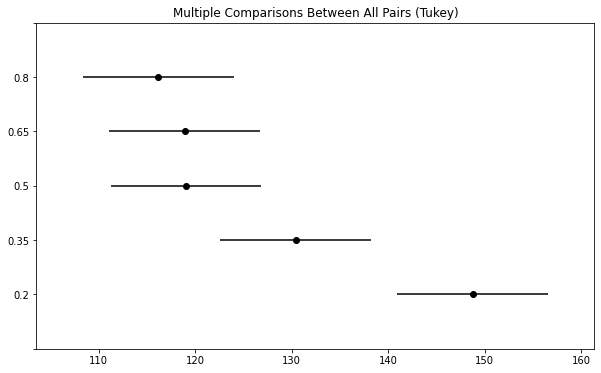

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0.2,0.35,-18.3413,0.0125,-33.9603,-2.7222,1.0
0.2,0.50,-29.7004,0.0010,-45.3194,-14.0814,1.0
0.2,0.65,-29.8499,0.0010,-45.4689,-14.2309,1.0
0.2,0.80,-32.5898,0.0010,-48.2088,-16.9708,1.0


In [143]:
display(anova_test(ls_data,'fuel_consumption_final','mutation'))
display(anova_test(ls_data,'fuel_consumption_final','paramGroup'))
anova_plot(ls_data,'fuel_consumption_final','mutation')

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,74175.396715,4,18543.849179,36.663263,6.621120e-28,0.170002
1,Within,362144.418098,716,505.788293,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,paramGroup,85112.456495,24,3546.352354,7.027931,7.823629e-21,0.195069
1,Within,351207.358317,696,504.608273,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

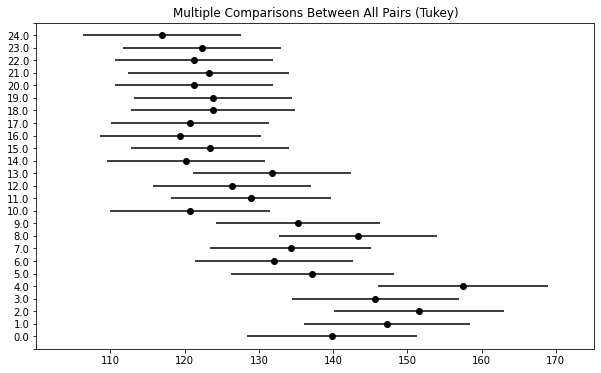

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0.0,24.0,-22.9635,0.0310,-45.0718,-0.8551,1.0
1.0,10.0,-26.5541,0.0029,-48.6200,-4.4882,1.0
1.0,14.0,-27.0736,0.0017,-48.9615,-5.1857,1.0
1.0,15.0,-23.8834,0.0154,-45.7713,-1.9955,1.0
1.0,16.0,-27.8299,0.0012,-49.8958,-5.7640,1.0
...,...,...,...,...,...,...
8.0,16.0,-23.8650,0.0117,-45.3520,-2.3780,1.0
8.0,17.0,-22.5810,0.0234,-43.8851,-1.2769,1.0
8.0,20.0,-22.0981,0.0315,-43.4022,-0.7940,1.0


In [151]:
display(anova_test(ga_data,'fuel_consumption_final','mutation'))
display(anova_test(ga_data,'fuel_consumption_final','paramGroup'))
anova_plot(ga_data,'fuel_consumption_final','paramGroup')

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,84086.151471,4,21021.537868,41.272049,2.855972e-31,0.181398
1,Within,379458.889515,745,509.340791,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,paramGroup,91645.013295,24,3818.542221,7.444052,1.832193e-22,0.197705
1,Within,371900.027690,725,512.965555,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

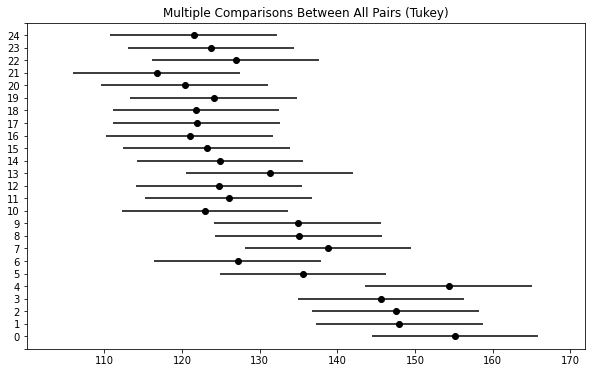

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0,6.0,-27.9959,0.0010,-49.4721,-6.5196,1.0
0,10.0,-32.2310,0.0010,-53.7073,-10.7547,1.0
0,11.0,-29.1838,0.0010,-50.6601,-7.7075,1.0
0,12.0,-30.4297,0.0010,-51.9060,-8.9534,1.0
0,13.0,-23.8730,0.0115,-45.3493,-2.3968,1.0
...,...,...,...,...,...,...
4,21.0,-37.6039,0.0010,-59.0801,-16.1276,1.0
4,22.0,-27.4589,0.0010,-48.9352,-5.9826,1.0
4,23.0,-30.6157,0.0010,-52.0920,-9.1395,1.0


In [152]:
display(anova_test(nsga2_data,'fuel_consumption_final','mutation'))
display(anova_test(nsga2_data,'fuel_consumption_final','paramGroup'))
anova_plot(nsga2_data,'fuel_consumption_final','paramGroup')

,Source,SS,DF,MS,F,p-unc,np2
0,paramGroup,61790.662422,24,2574.610934,4.883475,5.070817e-13,0.139163
1,Within,382226.403281,725,527.208832,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

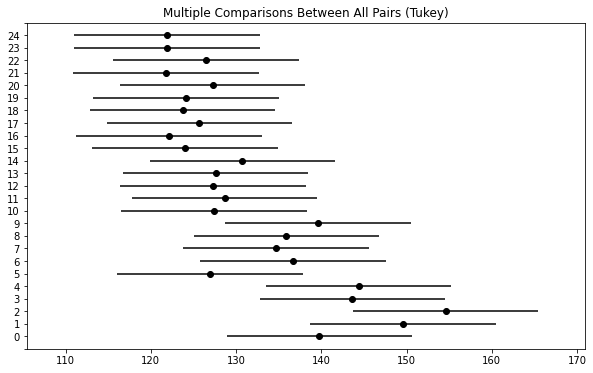

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
1,5.0,-22.6832,0.0297,-44.4556,-0.9108,1.0
1,10.0,-22.1690,0.0401,-43.9413,-0.3966,1.0
1,12.0,-22.3040,0.0371,-44.0764,-0.5316,1.0
1,13.0,-21.9963,0.0442,-43.7687,-0.2239,1.0
1,15.0,-25.5604,0.0046,-47.3328,-3.7881,1.0
1,16.0,-27.5010,0.0011,-49.2734,-5.7286,1.0
1,17.0,-23.9023,0.0140,-45.6747,-2.1299,1.0
1,18.0,-25.8640,0.0037,-47.6364,-4.0916,1.0
1,19.0,-25.4980,0.0048,-47.2704,-3.7256,1.0


In [153]:
display(anova_test(nsga3_data,'fuel_consumption_final','paramGroup'))
anova_plot(nsga3_data,'fuel_consumption_final','paramGroup')

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,42750.551339,4,10687.637835,19.832612,1.573534e-15,0.096236
1,Within,401474.620777,745,538.892108,NaN,NaN,NaN


,Source,SS,DF,MS,F,p-unc,np2
0,paramGroup,53060.458083,24,2210.852420,4.09768,3.622985e-10,0.119445
1,Within,391164.714033,725,539.537537,NaN,NaN,NaN


/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

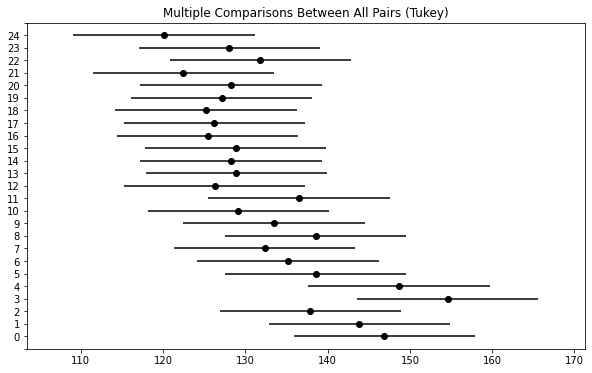

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0,21.0,-24.4598,0.0117,-46.4853,-2.4343,1.0
0,24.0,-26.7906,0.0024,-48.8161,-4.7651,1.0
1,24.0,-23.7581,0.0182,-45.7836,-1.7326,1.0
3,7.0,-22.2542,0.0442,-44.2797,-0.2287,1.0
3,10.0,-25.4715,0.0060,-47.4970,-3.4460,1.0
3,12.0,-28.3173,0.0010,-50.3428,-6.2918,1.0
3,13.0,-25.7155,0.0051,-47.7410,-3.6900,1.0
3,14.0,-26.3552,0.0032,-48.3807,-4.3297,1.0
3,15.0,-25.8016,0.0048,-47.8271,-3.7761,1.0


In [156]:
display(anova_test(hype_data,'fuel_consumption_final','mutation'))
display(anova_test(hype_data,'fuel_consumption_final','paramGroup'))
anova_plot(hype_data,'fuel_consumption_final','paramGroup')

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

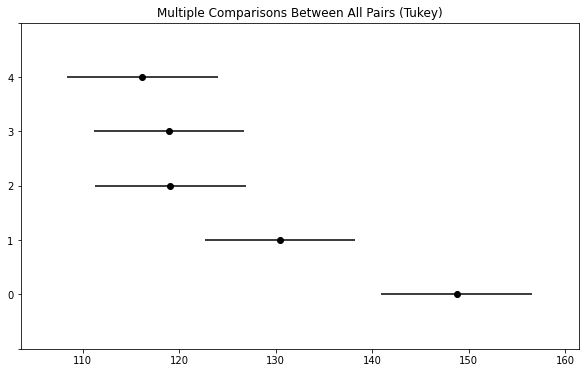

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0,1.0,-18.3413,0.0125,-33.9603,-2.7222,1.0
0,2.0,-29.7004,0.0010,-45.3194,-14.0814,1.0
0,3.0,-29.8499,0.0010,-45.4689,-14.2309,1.0
0,4.0,-32.5898,0.0010,-48.2088,-16.9708,1.0


In [155]:
anova_plot(ls_data,'fuel_consumption_final','paramGroup')

In [107]:
import pingouin as pg

aov = pg.anova(dv='fuel_consumption_final',between = 'mutation',data=sa_data,detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,mutation,3300.355269,4,825.088817,1.886768,0.115897,0.0498
1,Within,62971.587329,144,437.302690,NaN,NaN,NaN


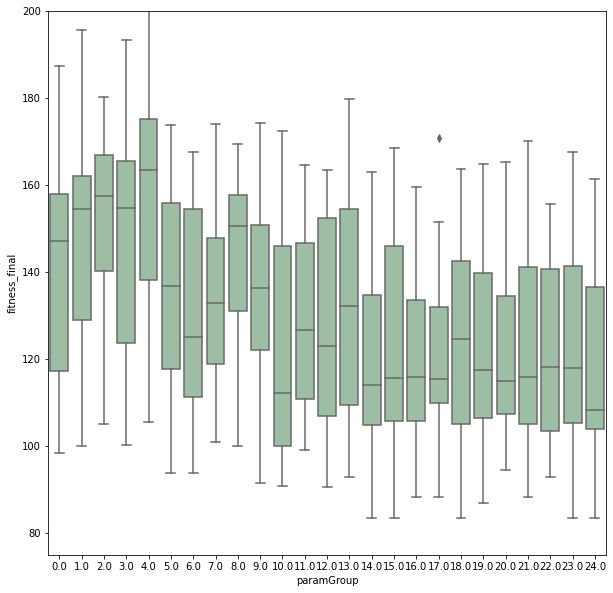

In [150]:
# generate a boxplot to see the data distribution by treatments. Using boxplot, we can 
# easily detect the differences between different treatments
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10,10))
ax = sns.boxplot(x='paramGroup', y='fitness_final', data=ga_data, color='#99c2a2')
ax.set_ylim(75,200)
#ax = sns.swarmplot(x="mutation", y="fitness_final", data=nsgaiii_data, color='#7d0013')
plt.show()

In [20]:

nsgaiii_data.boxplot('fitness_final',by='paramGroup',figsize=(10,10))

NameError: name 'nsgaiii_data' is not defined

In [ ]:
from bioinfokit.analys import stat
# perform multiple pairwise comparison (Tukey's HSD)
# unequal sample size data, tukey_hsd uses Tukey-Kramer test
res = stat()
res.tukey_hsd(df=ls_data, res_var='fitness_final', xfac_var='paramGroup', anova_model='fitness_final ~ C(paramGroup)')
res.tukey_summary

/home/andreash/Documents/School/Master_Thesis/Explorer/env/lib/python3.9/site-packages/statsmodels/sandbox/stats/multicomp.py:775: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(np.insert(self.groupsunique.astype(str), 0, ''))


<Figure size 720x720 with 0 Axes>

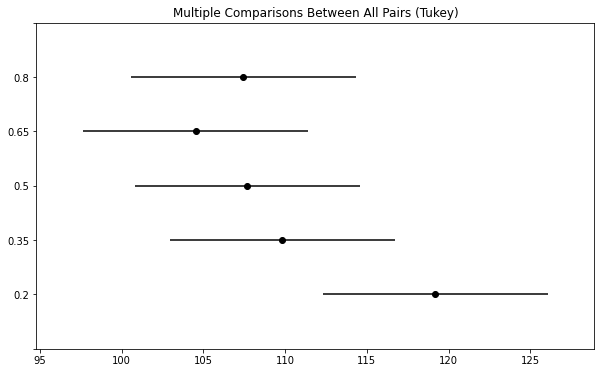

group1,group2,meandiff,p-adj,lower,upper,reject
0.2,0.35,-9.3643,0.3343,-23.1448,4.4163,False
0.2,0.5,-11.4979,0.1492,-25.2784,2.2827,False
0.2,0.65,-14.6747,0.0307,-28.4552,-0.8941,True
0.2,0.8,-11.7497,0.1336,-25.5302,2.0309,False
0.35,0.5,-2.1336,0.9,-15.9142,11.647,False
0.35,0.65,-5.3104,0.8011,-19.091,8.4702,False
0.35,0.8,-2.3854,0.9,-16.166,11.3952,False
0.5,0.65,-3.1768,0.9,-16.9574,10.6038,False
0.5,0.8,-0.2518,0.9,-14.0324,13.5287,False
0.65,0.8,2.925,0.9,-10.8556,16.7056,False


In [22]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
plt.figure(figsize=(10,10))
tukey = pairwise_tukeyhsd(endog=ls_data.fitness_final,groups=ls_data.mutation,alpha=0.05)

tukey.plot_simultaneous()
plt.show()
tukey.summary()

In [ ]:
LRresult = (tukey.summary().table[1])

,group2,meandiff,p-adj,lower,upper,reject
group1,,,,,,
0.20,0.35,-9.3643,0.3343,-23.1448,4.4163,False
0.20,0.50,-11.4979,0.1492,-25.2784,2.2827,False
0.20,0.65,-14.6747,0.0307,-28.4552,-0.8941,True
0.20,0.80,-11.7497,0.1336,-25.5302,2.0309,False
0.35,0.50,-2.1336,0.9000,-15.9142,11.6470,False
0.35,0.65,-5.3104,0.8011,-19.0910,8.4702,False
0.35,0.80,-2.3854,0.9000,-16.1660,11.3952,False
0.50,0.65,-3.1768,0.9000,-16.9574,10.6038,False
0.50,0.80,-0.2518,0.9000,-14.0324,13.5287,False


In [183]:
pd.DataFrame(tukey.summary(),columns=['group1','group2','meandiff','p-adj','lower','upper','reject'])

,group1,group2,meandiff,p-adj,lower,upper,reject
0,group1,group2,meandiff,p-adj,lower,upper,reject
1,0.2,0.35,-9.3643,0.3343,-23.1448,4.4163,False
2,0.2,0.5,-11.4979,0.1492,-25.2784,2.2827,False
3,0.2,0.65,-14.6747,0.0307,-28.4552,-0.8941,True
4,0.2,0.8,-11.7497,0.1336,-25.5302,2.0309,False
5,0.35,0.5,-2.1336,0.9,-15.9142,11.647,False
6,0.35,0.65,-5.3104,0.8011,-19.091,8.4702,False
7,0.35,0.8,-2.3854,0.9,-16.166,11.3952,False
8,0.5,0.65,-3.1768,0.9,-16.9574,10.6038,False
9,0.5,0.8,-0.2518,0.9,-14.0324,13.5287,False


In [63]:
tukey.summary()

group1,group2,meandiff,p-adj,lower,upper,reject
0.2,0.35,-9.3643,0.3343,-23.1448,4.4163,False
0.2,0.5,-11.4979,0.1492,-25.2784,2.2827,False
0.2,0.65,-14.6747,0.0307,-28.4552,-0.8941,True
0.2,0.8,-11.7497,0.1336,-25.5302,2.0309,False
0.35,0.5,-2.1336,0.9,-15.9142,11.647,False
0.35,0.65,-5.3104,0.8011,-19.091,8.4702,False
0.35,0.8,-2.3854,0.9,-16.166,11.3952,False
0.5,0.65,-3.1768,0.9,-16.9574,10.6038,False
0.5,0.8,-0.2518,0.9,-14.0324,13.5287,False
0.65,0.8,2.925,0.9,-10.8556,16.7056,False


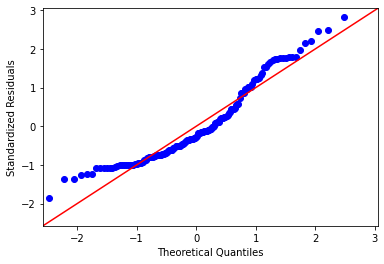

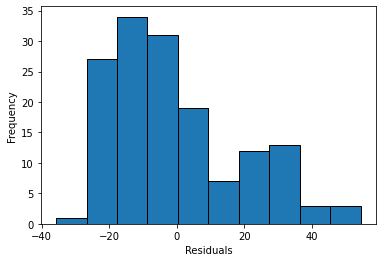

In [47]:
# QQ-plot
import statsmodels.api as sm
import matplotlib.pyplot as plt
# res.anova_std_residuals are standardized residuals obtained from ANOVA (check above)
sm.qqplot(res.anova_std_residuals, line='45')
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()

# histogram
plt.hist(res.anova_model_out.resid, bins='auto', histtype='bar', ec='k') 
plt.xlabel("Residuals")
plt.ylabel('Frequency')
plt.show()

In [301]:
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

lm = ols('fitness_final ~ C(paramGroup)',data=nsgaiii_data).fit()
anova_result = sm.stats.anova_lm(lm,typ=2)
anova_result

,sum_sq,df,F,PR(>F)
C(paramGroup),8397.399643,15.0,2.675801,0.003266
Residual,13389.974132,64.0,NaN,NaN


In [302]:
anova_result.anova

<pandas_flavor.register.register_dataframe_method.<locals>.inner.<locals>.AccessorMethod at 0x7fb980105bb0>

In [151]:
sa_grouped = sa_data.groupby(['mutation','alpha'])


In [281]:
resid = lm.resid
symbols = ['D', '^']
colors = ['r', 'g', 'blue']
plt.figure(figsize=(6,6));
for values, group in sa_grouped:
    i,j = values
    group_num = i*2 + j - 1  # for plotting purposes
    x = [group_num] * len(group)
    print(x)
    print(group_num)
    plt.scatter(x, resid[group.index], marker=symbols[j], color=colors[i-1],
            s=144, edgecolors='black')
plt.xlabel('Group');
plt.ylabel('Residuals');

[0.1499999999999999]
0.1499999999999999


TypeError: list indices must be integers or slices, not numpy.float64

<Figure size 432x432 with 0 Axes>

In [157]:
sa_grouped

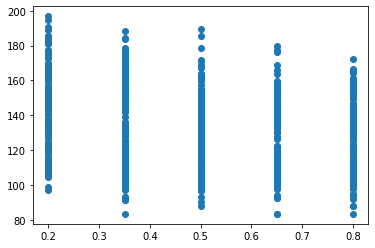

In [149]:
plt.scatter(nsga3_data.mutation,nsga3_data.fitness_final)#,c=algorithm_data[3].crossover)
